# Capacitated Facility Location Problem - Version #5

In [34]:
from pulp import *
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline

In [3]:
version_number = 5

In [413]:
# Define the manure utilization goal
manure_utilization_goal = 0.1

### Run the model

In [414]:
# Import farm_cluster_mock_5 dataset - which is the mock data for potential digester locations
potential_digester_location = pd.read_csv(r'./farm_cluster_mock_5.csv')
potential_digester_location.head()

,x,y,count
0,6.870686,52.215190,25
1,6.554937,52.254895,25
2,6.730518,52.252885,42
3,6.914234,52.387401,18
4,6.664105,52.392622,32


In [415]:
# Define the capacities of digester
medium_digester_capacity = 78480  # in tonne/yr
large_digester_capacity = 150560  # in tonne/yr

In [416]:
# Define the costs of digester 
medium_digester_cost = 209249   # in euro CAPEX
large_digester_cost = 252616    # in euro CAPEX

In [417]:
potential_digester_location = potential_digester_location.drop(['count'], axis=1) # drop unnecessary column

In [418]:
# Create mock digester capacity data
potential_digester_location['capacity'] = [medium_digester_capacity, medium_digester_capacity, large_digester_capacity, large_digester_capacity, large_digester_capacity]

# Create mock digester cost data
potential_digester_location['cost'] = [medium_digester_cost, medium_digester_cost, large_digester_cost, large_digester_cost, large_digester_cost]

In [419]:
farm = pd.read_csv(r"./farm_mock.csv")
farm.head()

,Unnamed: 0,x,y,IND_OBJ_NA,manure_t,biogas_potential_m3
0,0,6.765843,52.314139,507920,2454,957060.0
1,1,6.837249,52.425084,507950,9827,3832530.0
2,2,6.859361,52.386225,507953,8660,3377400.0
3,3,6.753483,52.434382,507962,2913,1136070.0
4,4,6.484077,52.243620,507964,6488,2530320.0


In [420]:
# farm = pd.DataFrame(farm.sample(n=15, random_state=42))
# farm

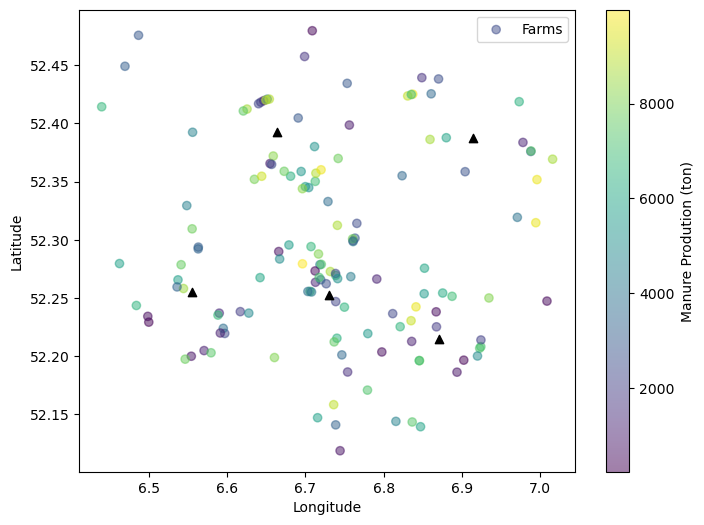

In [421]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(farm['x'], farm['y'], c=farm['manure_t'], alpha=0.5, label="Farms")
plt.scatter(potential_digester_location['x'], potential_digester_location['y'], marker='^', c='black')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.title('Farm Clusters and Cluster Centroids')
cbar = plt.colorbar(scatter)

# Add labels to the colorbar
cbar.set_label('Manure Prodution (ton)')
plt.legend()
plt.show()

In [422]:
# Open the file for reading
with open("./transportation_cost.txt", "r") as fp:
    # Load the dictionary from the file
    transportation_cost = json.load(fp)

In [423]:
# Function to recursively convert dictionary keys to integers
def convert_keys_to_int(data):
    if isinstance(data, dict):
        return {int(key) if key.isdigit() else key: convert_keys_to_int(value) for key, value in data.items()}
    else:
        return data

# Convert the keys to integers
transportation_cost = convert_keys_to_int(transportation_cost)

In [424]:
for key, value in transportation_cost.items():
    print(f"{key}: {value}")

0: {0: 16.822292415186183, 1: 30.92678676733662, 2: 23.080232076563743, 3: 33.11418499953114, 4: 29.356686731100446, 5: 27.41710293178537, 6: 27.41710293178537, 7: 27.41710293178537, 8: 28.393829138915116, 9: 20.243105076787128, 10: 41.9612403626698, 11: 24.694036491927427, 12: 24.694036491927427, 13: 24.694036491927427, 14: 6.069888650558055, 15: 6.041608434693484, 16: 3.6984204997384635, 17: 4.749865433194389, 18: 4.800831043411421, 19: 6.9265145012485725, 20: 8.379585194747122, 21: 30.92678676733662, 22: 28.662957735301266, 23: 4.337480138541471, 24: 12.376571362498016, 25: 20.83828686389431, 26: 10.127768119498189, 27: 11.623676101427407, 28: 12.380453853312831, 29: 8.77946693119841, 30: 15.658359298495212, 31: 19.95668779518618, 32: 31.395057232114276, 33: 17.261318975042318, 34: 17.929386750054004, 35: 24.739822426244267, 36: 25.019588446244263, 37: 17.045507814370396, 38: 21.44247636432336, 39: 14.49822946887925, 40: 10.988322125436566, 41: 12.073425355643696, 42: 12.07342535564

In [425]:
# Lists (sets / Array) of Customers and Facilities
Farm = farm.index.tolist()  # Customer = [1,2,3,4,5]
Plant = potential_digester_location.index.tolist()    # Facility = ['Fac-1', 'Fac-2', 'Fac-3']

In [426]:
# Dictionaries of the demands and facilities as well as fixed cost at each facility
Manure_Production = farm['manure_t'].to_dict()  # Demand = {1 : 80, 2 : 270, 3 : 250, 4 : 160, 5 : 180}
Max_Capacity = potential_digester_location['capacity'].to_dict()    # Max_Supply = {'Fac-1' : 500, 'Fac-2' : 500, 'Fac-3' : 500} 
Fixed_Cost = potential_digester_location['cost'].to_dict()  # fixed_cost = {'Fac-1' : 1000, 'Fac-2' : 1000, 'Fac-3' : 1000 }

In [427]:
# string_values = {}
# non_string_values = {}

# for key, value in transportation_cost.items():
#     if isinstance(value, str):
#         string_values[key] = value
#     else:
#         non_string_values[key] = value

# print("String Values:")
# print(string_values)

# print("\nNon-String Values:")
# print(non_string_values)

In [428]:
# # Create a mock distance matrix to store the euclidean distance between each potential digester location to every farm
# transportation_cost = {} # NOTE THE TRANSPORTATION COST MATRIX IS A !DISTANCE MATRIX!

# for plant_idx, plant_row in potential_digester_location.iterrows():
#     plant_coords = (plant_row['y'], plant_row['x'])
#     transportation_cost[plant_idx] = {}  # Create an inner dictionary for each plant

#     for farm_idx, farm_row in farm.iterrows():
#         farm_coords = (farm_row['y'], farm_row['x'])
#         distance = euclidean(plant_coords, farm_coords)
#         transportation_cost[plant_idx][farm_idx] = distance

# # transportation_cost

In [429]:
# Define the total manure production by all farms
Total_Manure_Production = sum(Manure_Production[i] for i in Farm)

In [430]:
# Setting the Problem
prob = LpProblem("Capacitated_Facility_Location_Problem_V1", LpMinimize)

In [431]:
# Defining our Decision Variables
use_plant = LpVariable.dicts("Plant", Plant, 0, 1, LpBinary) 
ser_farm = LpVariable.dicts("Farm_Plant", [(i, j) for i in Farm for j in Plant], 0, 1, LpBinary) 
# ser_farm = LpVariable.dicts("Farm_Plant", [(i,j) for i in Farm for j in Plant], 0)  

In [432]:
# Define binary decision variables for farm assignment
# farm_assignment = LpVariable.dicts("Farm_Assignment", Farm, 0, 1, LpBinary)

# # Create a binary variable to indicate if a farm supplies a plant
# farm_supplies_plant = LpVariable.dicts("Farm_Supplies_Plant", [(i, j) for i in Farm for j in Plant], 0, 1, LpBinary)

In [433]:
# Setting the Objective Function
# prob += lpSum(Fixed_Cost[j]*use_plant[j] for j in Plant) + lpSum(transportation_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

prob += lpSum(Fixed_Cost[j]*use_plant[j] for j in Plant) + lpSum(transportation_cost[j][i]*ser_farm[(i,j)] for j in Plant for i in Farm)

    # prob += lpSum(fixed_cost[j]*use_facility[j] for j in Facility) + lpSum(transportation_cost[j][i]*ser_customer[(i,j)] for j in Facility for i in Customer)

In [434]:
# Costraints

for i in Farm:
    prob += lpSum(ser_farm[(i, j)] for j in Plant) <= 1 # Very strange, the model becomes infeasible  if it's == 1, maybe because now the constraint has relaxed and not all farms need to be assigned to facility, which will be the case if ==1

# The capacity constraint here it differnt than the one in paper, but i think it does the work still
for j in Plant:
    prob += lpSum(Manure_Production[i] * ser_farm[(i,j)] for i in Farm) <= Max_Capacity[j]*use_plant[j]

# Not really sure what this constraint does, I think it makes sure a farm can only be assigned to a facility given it's open, hence the value of xij is smaller or equal to yj 
for i in Farm:
    for j in Plant:
        prob += ser_farm[(i,j)] <= use_plant[j]

# Add a constraint to ensure at least x% of total manure production is sent to plants
prob += lpSum(Manure_Production[i] * ser_farm[(i, j)] for i in Farm for j in Plant) >= manure_utilization_goal * Total_Manure_Production

In [435]:
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/wenyuc/opt/anaconda3/envs/bioze/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/3bd933b34a814ef8ab78d4fe23a926f8-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/3bd933b34a814ef8ab78d4fe23a926f8-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 863 COLUMNS
At line 6564 RHS
At line 7423 BOUNDS
At line 8139 ENDATA
Problem MODEL has 858 rows, 715 columns and 3555 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 118321 - 0.00 seconds
Cgl0008I 142 inequality constraints converted to equality constraints
Cgl0004I processed model has 858 rows, 857 columns (857 integer (857 of which binary)) and 3697 elements
Cbc0038I Initial state - 49 integers unsatisfied sum - 22.9174
Cbc

1

In [436]:
status = LpStatus[prob.status]


In [437]:
print("Solution Status = ", LpStatus[prob.status])

Solution Status =  Optimal


In [438]:
# if status == "Optimal":
#     # Retrieve and store the variable values
#     optimal_x = use_facility.varValue
#     optimal_y = ser_customer.varValue

#     # Retrieve and store the optimal objective value
#     optimal_obj_value = prob.objective.value()
# else:
#     optimal_x = None
#     optimal_y = None
#     optimal_obj_value = None

# print("Optimization Status:", status)
# print("Optimal x:", optimal_x)
# print("Optimal y:", optimal_y)
# print("Optimal Objective Value:", optimal_obj_value)

In [439]:
# # Print the status of the optimization
# print("Optimization Status:", LpStatus[prob.status])

# # Print the optimal values of decision variables
# for j in Facility:
#     print(f"Use Facility {j}: {use_facility[j].varValue}")

# for i in Customer:
#     for j in Facility:
#         print(f"Service customer {i} from Facility {j}: {ser_customer[(i, j)].varValue}")

In [440]:
# # Print the solution of Binary Decision Variables
# Tolerance = 0.0001
# for j in Plant:
#     if use_plant[j].varValue > Tolerance:
#         print("Estalish Facility at site = ", j)

In [441]:
# Print the solution of Continuous Decision Variables
# for v in prob.variables():
#     print(v.name, "=", v.varValue)

In [442]:
# Initialize lists to store assignment information
assigned_farms = {j: [] for j in Plant}

# Collect assigned farms
for i in Plant:
    for j in Farm:
        if ser_farm[(j,i)].varValue > 0.00001:
            assigned_farms[i].append(j)

In [443]:
assigned_farms

{0: [14, 16, 17, 19, 23, 43, 45, 78, 82, 84], 1: [], 2: [], 3: [], 4: []}

### Note that...
When an optimal solution is infeasible, the assignment matrix generated will not be binary. For example in the case of 15 farms and given the totoal capacity of the maximum 5 plants that can be opened, the maximum total manure utilization goal can only be 0.7. Because the total capacity of 5 plants, if they're all open, would be slightly less than 80% of the total manure production. 

In [444]:
# assignment_matrix = pd.DataFrame(index=facilities, columns=customers)

# for i in facilities:
#     for j in customers:
#         assignment_matrix.at[i, j] = x[(i, j)].varValue

assignment_matrix = pd.DataFrame(index=Farm, columns=Plant)

for i in Plant:
    for j in Farm:
        assignment_matrix.at[j, i] = ser_farm[(j, i)].varValue

assignment_matrix

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
137,0.0,0.0,0.0,0.0,0.0
138,0.0,0.0,0.0,0.0,0.0
139,0.0,0.0,0.0,0.0,0.0
140,0.0,0.0,0.0,0.0,0.0


In [445]:
# Print the assignment of clients to plants
# for i in Farm:
#     for j in Plant:
#         if ser_farm[(i, j)].varValue == 1:
#             print(f"Assign {i} to {j}")
for i in Farm:
    for j in Plant:
        if ser_farm[(i, j)].varValue > 0 :
            print(f"Assign {i} to {j}")

Assign 14 to 0
Assign 16 to 0
Assign 17 to 0
Assign 19 to 0
Assign 23 to 0
Assign 43 to 0
Assign 45 to 0
Assign 78 to 0
Assign 82 to 0
Assign 84 to 0


In [446]:
# Check if the opened plants are under-utilized
potential_digester_location['allocated_manure'] = assignment_matrix.sum(axis = 0)
potential_digester_location

,x,y,capacity,cost,allocated_manure
0,6.870686,52.215190,78480,209249,10.0
1,6.554937,52.254895,78480,209249,0.0
2,6.730518,52.252885,150560,252616,0.0
3,6.914234,52.387401,150560,252616,0.0
4,6.664105,52.392622,150560,252616,0.0


In [447]:
# Find the percentage of plant's capacity that is utilized 

potential_digester_location['percentage_utilized'] = 0

for index, row in potential_digester_location.iterrows():
    if row['allocated_manure'] > 0:
        potential_digester_location.at[index, 'percentage_utilized'] = (row['allocated_manure'] / row['capacity']) * 100

/var/folders/w_/w1t73xzx35j4jtrj94fjskj80000gn/T/ipykernel_25592/3950044958.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.012742099898063202' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  potential_digester_location.at[index, 'percentage_utilized'] = (row['allocated_manure'] / row['capacity']) * 100


In [448]:
def find_farm_not_in_solution_plant_in_solution(solution_dictionary, farm_df):
    """
    Input:
        solution_dictionary: dictionary of model output {plant:[all the assigned farms]}
        farm_df: DataFrame of farm data

    Return:
        empty_keys_unused_plant: a list of indices of unused plants
        farm_not_in_solution: a list of indices of excluded farms
    """
    
    # Find plants that in the optimal solution
    plant_in_use = []
    
    for key, value in solution_dictionary.items():
        if value is not None and not (
            (isinstance(value, str) and value.strip() == '') or
            (isinstance(value, (list, dict)) and not value)
        ):
            plant_in_use.append(key)
    
    # Find farms that are excluded in the optimal solution aka. it is not assigned to any plants
    # Append the lists from the dictionary to a combined list
    combined_dict = []

    for key in solution_dictionary:
        combined_dict.extend(solution_dictionary[key])
    
    farm_not_in_solution = []

    for index_value in farm_df.index:
        if index_value not in combined_dict:
            farm_not_in_solution.append(index_value)
    
    return plant_in_use, farm_not_in_solution 

In [449]:
plant_in_use, farm_not_in_solution = find_farm_not_in_solution_plant_in_solution(assigned_farms, farm)

In [450]:
# # Count the number of farms assigned to each plant
# for j in Plant:
#     assigned = assigned_farms[j]
#     print(len(assigned))

In [451]:
# # Check the indices of farms assigned to each plant
# for j in Plant:
#     assigned = assigned_farms[j]
#     print(assigned)

PROBLEM!! The number of farms that are not_in_any_solution combined with all the farms that are included add up to 143, which is 1 more than the actual count of farms....

Just checked and *18* has duplicates. So Farm 18 is assigned to Plant 1 and 4. 


In [452]:
# Check duplicates

# Initialize a dictionary to store seen values
seen = {}
# Initialize a list to store duplicate values
duplicates = []

# Iterate through the list
for item in farm_not_in_solution:
    # If the item is already in the dictionary, it's a duplicate
    if item in seen:
        duplicates.append(item)
    else:
        seen[item] = True

if duplicates:
    print("Duplicate values:", duplicates)
else:
    print("There are no duplicates in the list.")

There are no duplicates in the list.


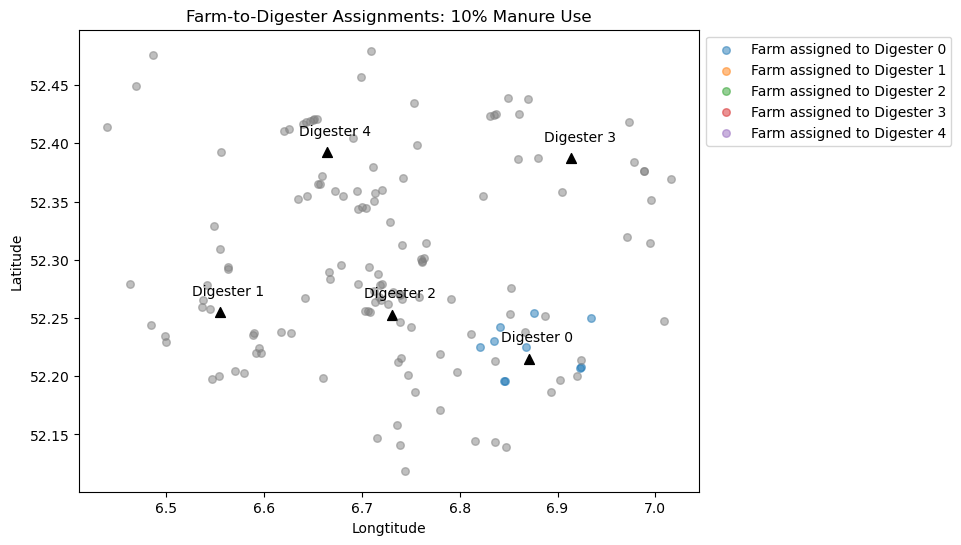

In [453]:
# Visualize the results
plt.figure(figsize=(8, 6))
 
for i in Plant:
    plt.scatter(potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y'], marker="^", s=50, c='Black')
    # label = f"Plant {i} \n Capacity:{potential_digester_location.loc[i, 'capacity']} (t/yr)"
    label = f"Digester {i}"
    plt.annotate(label, # this is the text
                 (potential_digester_location.loc[i, 'x'], potential_digester_location.loc[i, 'y']), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(-20,10), # distance from text to points (x,y)
                 ha='left', va='bottom') # horizontal alignment can be left, right or center 

# Plot farms in solution
for j in Plant:
    assigned = assigned_farms[j]
    plt.scatter([farm.loc[i, 'x'] for i in assigned], [farm.loc[i, 'y'] for i in assigned], label=f"Farm assigned to Digester {j}", marker='o', s=30, alpha=0.5)

# Plot farms excluded in solution
for i in farm_not_in_solution:
    plt.scatter(farm.loc[i, 'x'], farm.loc[i, 'y'], marker='o', s=30, c='Grey', alpha=0.5)

# Add labels and legend
plt.xlabel("Longtitude")
plt.ylabel("Latitude")
plt.title(f"Farm-to-Digester Assignments: {int(manure_utilization_goal*100)}% Manure Use")
# plt.legend()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
# legend = plt.legend(*scatter.legend_elements(), loc='upper left', bbox_to_anchor=(1.0, 1.0))

# # Create a dictionary to map unique values to custom legend labels
# custom_labels = {'A': 'Category 1', 'B': 'Category 2', 'C': 'Category 3'}

# # Replace unique values with custom labels for the legend
# legend_labels = [custom_labels[label] for label in df['Label'].unique()]

# # Create the legend with custom labels
# legend = plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, loc='upper left', bbox_to_anchor=(1.0, 1.0))

filename = f"./outputs/cflp_v{version_number}_{int(manure_utilization_goal*100)}%manure.png"  # You can choose the file extension (e.g., .png, .jpg, .pdf)

plt.savefig(filename, dpi=400)

plt.show()

In [454]:
# Print Optimal
print("Total Cost = ", value(prob.objective))

TypeError: 'dict' object is not callable